# Final Project
## Topic: Rumor Prediction 

#### Course: Social Media Mining F19 CIS6930
#### By Anfal AlYousufi & Khaled Alshatti
#### U72884742 & U46432860


In [176]:
#(anfal)

import re
import sys
import json
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

#headerline
from matplotlib.legend_handler import HandlerLine2D

#SVG 
from IPython.display import SVG

#confusion matrix
from mlxtend.evaluate import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix

#nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

#sklearn
import sklearn as sk
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import model_selection
from sklearn.utils import resample
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,make_scorer,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample

## Loading data set for tweet and tag

In [125]:
#(anfal)

def Load_dataset(path):
    with open(path) as json_data:
        text= json.load(json_data)
    new_data = []
    for x in text:
        new_insert = {}
        for i,v in x.items():
            if not isinstance(v, dict): #true for (v,dict)
                new_insert[i] = v # not dictionary 
            else:
                 for e,f in v.items():# flatten v
                    new_insert[e] = f
        new_data.append(new_insert)
    return pd.DataFrame(new_data)

path = 'Dataset.json'
tweet = Load_dataset(path)

# Clean Data: Preprocessing

In [140]:
#(anfal)
def process_tweet(tweet):
    
    tweet = tweet.lstrip(' ') #remove space beginning of tweet
    tweet = tweet.lower()#put all lowercase
    tweet = re.sub(r'\&\w*;', '', tweet)#remove HTML entities
    tweet = re.sub(r'#\w*', '', tweet)#remove hashtag
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)#remove hyperlink
    tweet = re.sub("[^a-zA-Z]"," ",tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)#remove newline & whitespace
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet) #remove words with 2< letters
    
    return tweet

tweet['strong_pro1'] = tweet['text'].apply(process_tweet)
tweet.head(n=254)


,tag,text,strong_pro1,strong_pro,Stemming
0,real,Exclusive: Aramco agrees on price for Sabic ac...,exclusive aramco agrees price for sabic acquis...,exclusive aramco agrees price for sabic acqui...,exclus aramco agre price for sabic acquisit
1,real,#Digitisation contract signed in #SaudiArabia ...,digitisation contract signed saudiarabia for t...,contract signed for two holy mosques,contract sign for two holi mosqu
2,fake,The #Taliban will not attend planned peace tal...,the taliban will not attend planned peace talk...,the will not attend planned peace talks with t...,the will not attend plan peac talk with the ar...
3,real,#Qatar have used #Khashoggi to write all of th...,qatar have used khashoggi write all the articl...,have used write all the articles beside us...,have use write all the articl besid use him fo...
4,real,#Saudi sets clear rules and regulations to pro...,saudi sets clear rules and regulations protect...,sets clear rules and regulations protect wil...,set clear rule and regul protect wildlif the k...
5,real,#Saudi ministry of justice works on developing...,saudi ministry justice works developing commer...,ministry justice works developing commercia...,ministri justic work develop commerci justic p...
6,fake,#فتاه_تايلند\nA #Saudi woman who’s trying to f...,saudi woman who trying flee into asylum being ...,woman who trying flee into asylum being h...,woman who tri flee into asylum be held airport...
7,real,#Saudi woman detained in #Thailand seeks asylu...,saudi woman detained thailand seeks asylum can...,woman detained seeks asylum she sought asyl...,woman detain seek asylum she sought asylum can...
8,real,Saudi Government paid SR 6million blood money...,saudi government paid million blood money rele...,saudi government paid million blood money re...,saudi govern paid million blood money releas j...
9,fake,Gunfire Heard At Saudi Royal Palace In Riyadh ...,gunfire heard saudi royal palace riyadh rumors...,gunfire heard saudi royal palace riyadh rum...,gunfir heard saudi royal palac riyadh rumor at...


### Snowball Stemmer

In [139]:
#(anfal)
p = SnowballStemmer("english")
tweet['Stemming'] = tweet['strong_pro1'].apply(lambda x: ' '.join([p.stem(word) for word in x.split() ]))

tweet.head()

,tag,text,strong_pro1,strong_pro,Stemming
0,real,Exclusive: Aramco agrees on price for Sabic ac...,exclusive aramco agrees price for sabic acquis...,exclusive aramco agrees price for sabic acqui...,exclus aramco agre price for sabic acquisit
1,real,#Digitisation contract signed in #SaudiArabia ...,digitisation contract signed saudiarabia for t...,contract signed for two holy mosques,contract sign for two holi mosqu
2,fake,The #Taliban will not attend planned peace tal...,the taliban will not attend planned peace talk...,the will not attend planned peace talks with t...,the will not attend plan peac talk with the ar...
3,real,#Qatar have used #Khashoggi to write all of th...,qatar have used khashoggi write all the articl...,have used write all the articles beside us...,have use write all the articl besid use him fo...
4,real,#Saudi sets clear rules and regulations to pro...,saudi sets clear rules and regulations protect...,sets clear rules and regulations protect wil...,set clear rule and regul protect wildlif the k...


### Building countplot graph to show real from fake
#### We are increasing minority class
#### 0= real tag & 1 = fake tag

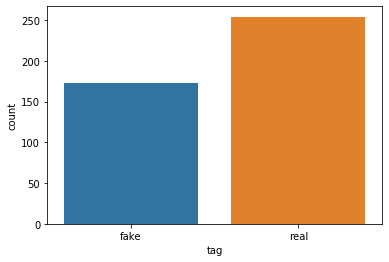

In [143]:
#(anfal)

s = tweet.copy()
df_minority = s[s.tag == "real"] #true 
df_majority = s[s.tag == "fake"] #rumor

df_minority = resample(df_minority, 
                       replace=True,  #sample with replacement 
                       #n_samples=len(df_majority),
                       n_samples=254, #to match majority class 
                       random_state=123 #reproducible results
                      )

df_balanced = pd.concat([df_majority, df_minority])
sns.countplot(df_balanced['tag'], label="count")

#ax.set (ylabel="Count")
plt.show()

# Pipeline : 

### 2 experiments with pipeline

#### 1: BoW(CountVectorizer()) + Classifier
#### 2: Tf-Idf (TfidfVectorizer( )) + Classifier

### 4 classifiers used
#### 1: K-NN classifier
#### 2: Multinomial NB classifier
#### 3: Suppoer Vector Matrix classifier 
#### 4: Decesion Tree classifier

### 4 experiment per classifier

#### I    BoW  + Preprocessed text 
#### II   BoW  + Preprocessed text + Stemming 
#### III  Tf-Idf + Preprocessed text 
#### IV  Tf-Idf + Preprocessed text + Stemming

# Kneighbors Classifier

#### Exp1: Bow + Preprocessed text

In [177]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', KNeighborsClassifier())])

grid = {
    'vectorizer__ngram_range': [[1, 1], [1, 2]],
    'classifier__n_neighbors':range(1,30)
}


grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [178]:
print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=[1, 1], preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=6, p=2,
                                      weights='uniform'))],
         verbo

#### print: confussion matrix & accuracy 

In [181]:
confusion=confusion_matrix (Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc, "\n")


print("\nHighest accuracy is as shown by gridSearchCv: " )

K_rang=range(1,30)
K_score=[]
for k in K_rang:
    pipelineTf_Idf = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english',analyzer='word',ngram_range=(1, 2))),
    ('classifier', KNeighborsClassifier(k))])
    
    model=pipelineTf_Idf.fit(X_train,Y_train)
    y_pred = model.predict(X_test)

    K_score.append(accuracy_score(Y_test, y_pred))
for i in K_score:
    print(i)


Confusion matrix 
 [[33 10]
 [11 53]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.75      0.77      0.76        43
           1       0.84      0.83      0.83        64

    accuracy                           0.80       107
   macro avg       0.80      0.80      0.80       107
weighted avg       0.80      0.80      0.80       107
 

Train Accuracy 0.89375
Test Accuracy: 0.8037383177570093
roc_auc_score 0.7977834302325582 


Highest accuracy is as shown by gridSearchCv: 
0.7289719626168224
0.5794392523364486
0.7757009345794392
0.6728971962616822
0.7570093457943925
0.7663551401869159
0.7009345794392523
0.7476635514018691
0.719626168224299
0.719626168224299
0.7102803738317757
0.7383177570093458
0.6915887850467289
0.6822429906542056
0.6728971962616822
0.7102803738317757
0.6822429906542056
0.6822429906542056
0.6635514018691588
0.6822429906542056
0.6542056074766355
0.6822429906542056
0.6822429906542056
0.6728971962616822
0.6822429906

C:\Users\Anfal\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


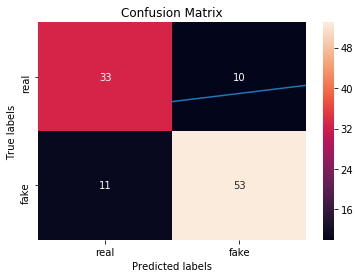

In [182]:
#polt the value of K for KNN
plt.plot(K_rang,K_score)
plt.xlabel("value of k for knn")
plt.ylabel("cross-valdition Accuracy")

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

#### Exp2: Bow + Preprocessed text +Stemming


In [183]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', KNeighborsClassifier())])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_neighbors':range(1,30)
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [19]:
print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1, p=2,
                                      weights='uniform'))],
         verbo

In [189]:

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")

print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)


print("the classifier accuracy and shows that the highest accuracy is as shown by gridSearchCv:")
K_rang=range(1,30)
K_score=[]
for k in K_rang:
    pipelineTf_Idf = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english',analyzer='word',ngram_range=(1, 2))),
    ('classifier', KNeighborsClassifier(k))])
    
    model=pipelineTf_Idf.fit(X_train,Y_train)
    y_pred = model.predict(X_test)

    K_score.append(accuracy_score(Y_test, y_pred))
for i in K_score:
    print(i)

C:\Users\Anfal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix 
 [[ 0 43]
 [ 0 64]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.60      1.00      0.75        64

    accuracy                           0.60       107
   macro avg       0.30      0.50      0.37       107
weighted avg       0.36      0.60      0.45       107
 

Train Accuracy 0.84375
Test Accuracy: 0.5981308411214953
roc_auc_score 0.5
0.719626168224299
0.719626168224299
0.7102803738317757
0.6915887850467289
0.6822429906542056
0.6822429906542056
0.6728971962616822
0.6915887850467289
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6542056074766355
0.6728971962616822
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.616822429906542
0.6355140186915887
0.6074766355140186
0.6261682242990654
0.6074766355140186
0.6074766355140186
0.6074766355140186
0.6074766355140186
0.5981308411214953
0.5981308411214953
0.

Text(0, 0.5, 'cross-valdition Accuracy')

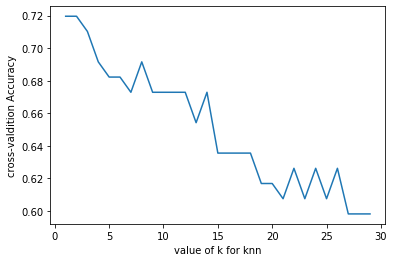

In [22]:
#polt the value of K for KNN
plt.plot(K_rang,K_score)
plt.xlabel("value of k for knn")
plt.ylabel("cross-valdition Accuracy")

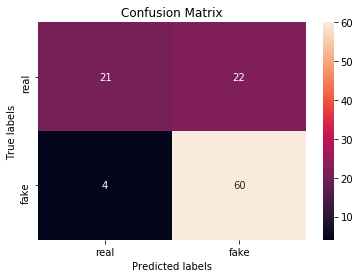

In [23]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

#### Exp3- Tf-Idf+ Preprocessed text 


In [190]:

x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', KNeighborsClassifier())])


grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_neighbors':range(1,30)
}


grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [27]:

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', me

### print confusion matrix and accuracy

In [28]:
best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[35  8]
 [11 53]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.76      0.81      0.79        43
           1       0.87      0.83      0.85        64

    accuracy                           0.82       107
   macro avg       0.81      0.82      0.82       107
weighted avg       0.83      0.82      0.82       107
 

Train Accuracy 1.0
Test Accuracy: 0.822429906542056
roc_auc_score 0.8210392441860466


In [29]:
# plot represents the classifier accuracy and shows that the highest accuracy is as shown by gridSearchCv
K_rang=range(1,30)
K_score=[]
for k in K_rang:
    pipelineTf_Idf = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english',analyzer='word',ngram_range=(1, 1))),
    ('classifier', KNeighborsClassifier(k))])
    
    model=pipelineTf_Idf.fit(X_train,Y_train)
    y_pred = model .predict(X_test)

    K_score.append(accuracy_score(Y_test, y_pred))
for i in K_score:
    print(i)

0.7570093457943925
0.7663551401869159
0.7009345794392523
0.6915887850467289
0.6915887850467289
0.7009345794392523
0.6822429906542056
0.6915887850467289
0.6822429906542056
0.6915887850467289
0.6728971962616822
0.6728971962616822
0.6635514018691588
0.6635514018691588
0.6635514018691588
0.6635514018691588
0.6542056074766355
0.6542056074766355
0.6542056074766355
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6355140186915887


Text(0, 0.5, 'cross-valdition Accuracy')

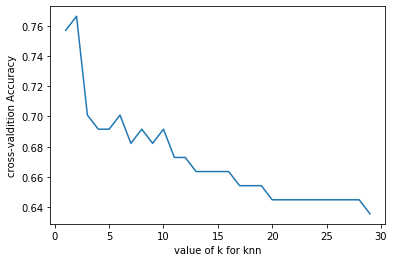

In [30]:

#polt the value of K for KNN
plt.plot(K_rang,K_score)
plt.xlabel("value of k for knn")
plt.ylabel("cross-valdition Accuracy")




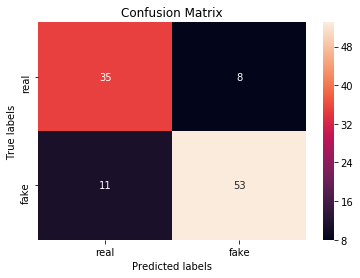

In [31]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

#### Exp4- Tf-Idf + Preprocessed text + Stemming

In [191]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', KNeighborsClassifier())])


grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_neighbors':range(1,30)
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [35]:

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name,  [param_name]))


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', me

## print confusion matrix and accuracy

In [36]:

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[36  7]
 [ 9 55]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.80      0.84      0.82        43
           1       0.89      0.86      0.87        64

    accuracy                           0.85       107
   macro avg       0.84      0.85      0.85       107
weighted avg       0.85      0.85      0.85       107
 

Train Accuracy 1.0
Test Accuracy: 0.8504672897196262
roc_auc_score 0.8482921511627906


In [37]:
# plot represents the classifier accuracy and shows that the highest accuracy is as shown by gridSearchCv
K_rang=range(1,30)
K_score=[]
for k in K_rang:
    pipelineTf_Idf = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english',analyzer='word',ngram_range=(1, 1))),
    ('classifier', KNeighborsClassifier(k))])
    
    model=pipelineTf_Idf.fit(X_train,Y_train)
    y_pred = model.predict(X_test)

    K_score.append(accuracy_score(Y_test, y_pred))
for i in K_score:
    print(i)

0.7570093457943925
0.7570093457943925
0.7102803738317757
0.7102803738317757
0.6915887850467289
0.6822429906542056
0.6728971962616822
0.6822429906542056
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6635514018691588
0.6728971962616822
0.6635514018691588
0.6728971962616822
0.6542056074766355
0.6635514018691588
0.6635514018691588
0.6635514018691588
0.6635514018691588
0.6635514018691588
0.6542056074766355
0.6542056074766355
0.6448598130841121
0.6542056074766355
0.6448598130841121


Text(0, 0.5, 'cross-valdition Accuracy')

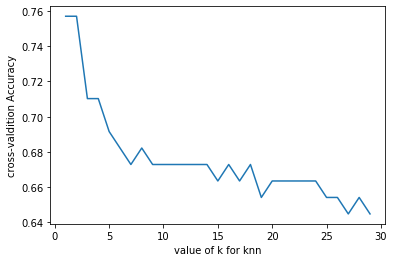

In [38]:
#polt the value of K for KNN
plt.plot(K_rang,K_score)
plt.xlabel("value of k for knn")
plt.ylabel("cross-valdition Accuracy")

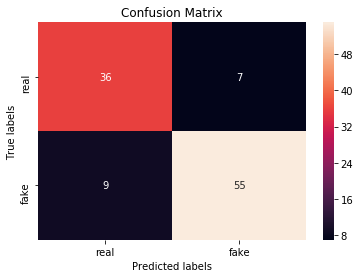

In [39]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

# Multinomial Naïve Bayes Classifier 

In [40]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}


grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [41]:

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False) 

	vectorizer__ngram_range: (1, 1)


In [42]:

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[38  5]
 [11 53]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.78      0.88      0.83        43
           1       0.91      0.83      0.87        64

    accuracy                           0.85       107
   macro avg       0.84      0.86      0.85       107
weighted avg       0.86      0.85      0.85       107
 

Train Accuracy 0.99375
Test Accuracy: 0.8504672897196262
roc_auc_score 0.8559229651162791


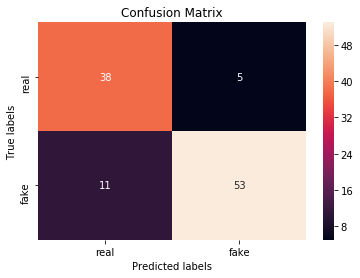

In [43]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

####  Exp2: Bow + Preprocessed text +Stemming


In [44]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)



GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [45]:
print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False) 

	vectorizer__ngram_range: (1, 1)


### print confusion matrix and accuracy

In [46]:
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[38  5]
 [13 51]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.75      0.88      0.81        43
           1       0.91      0.80      0.85        64

    accuracy                           0.83       107
   macro avg       0.83      0.84      0.83       107
weighted avg       0.84      0.83      0.83       107
 

Train Accuracy 0.990625
Test Accuracy: 0.8317757009345794
roc_auc_score 0.8402979651162791


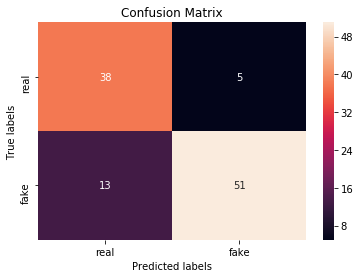

In [47]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

#### Exp3- Tf-Idf+ Preprocessed text 


In [192]:

x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [50]:
print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False) 

	vectorizer__ngram_range:

### Print confision matrix and accuracy

In [51]:
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[32 11]
 [ 5 59]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.86      0.74      0.80        43
           1       0.84      0.92      0.88        64

    accuracy                           0.85       107
   macro avg       0.85      0.83      0.84       107
weighted avg       0.85      0.85      0.85       107
 

Train Accuracy 0.990625
Test Accuracy: 0.8504672897196262
roc_auc_score 0.833030523255814


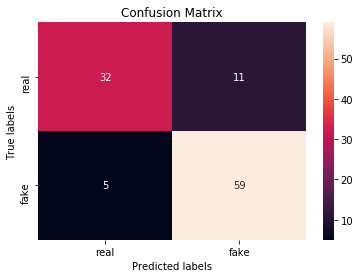

In [52]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

#### Exp4- Tf-Idf + Preprocessed text + Stemming

In [193]:

x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())])


grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [56]:

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False) 

	vectorizer__ngram_range:

### print confusion matrix and accuracy

In [57]:

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[34  9]
 [ 7 57]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.83      0.79      0.81        43
           1       0.86      0.89      0.88        64

    accuracy                           0.85       107
   macro avg       0.85      0.84      0.84       107
weighted avg       0.85      0.85      0.85       107
 

Train Accuracy 0.990625
Test Accuracy: 0.8504672897196262
roc_auc_score 0.8406613372093023


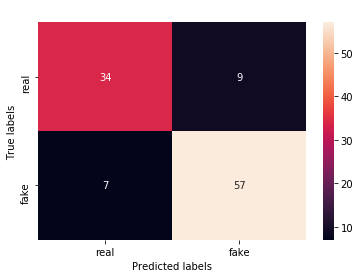

In [58]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title(' '); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

# Support Vector Machine Classifier 

#### Exp1: Bow + Preprocessed text

In [59]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', SVC(kernel='linear'))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C':[0.01,0.1,1,10]
}


grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [60]:

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
      

In [61]:

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[30 13]
 [ 6 58]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.83      0.70      0.76        43
           1       0.82      0.91      0.86        64

    accuracy                           0.82       107
   macro avg       0.83      0.80      0.81       107
weighted avg       0.82      0.82      0.82       107
 

Train Accuracy 0.984375
Test Accuracy: 0.822429906542056
roc_auc_score 0.8019622093023255


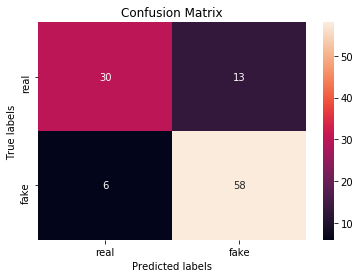

In [62]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

Exp2: Bow + Preprocessed text +Stemming


In [63]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', SVC(kernel='linear'))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C':[0.01,0.1,1,10]
}


grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)



GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [64]:

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
        

In [65]:

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[34  9]
 [ 9 55]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.79      0.79      0.79        43
           1       0.86      0.86      0.86        64

    accuracy                           0.83       107
   macro avg       0.83      0.83      0.83       107
weighted avg       0.83      0.83      0.83       107
 

Train Accuracy 1.0
Test Accuracy: 0.8317757009345794
roc_auc_score 0.8250363372093023


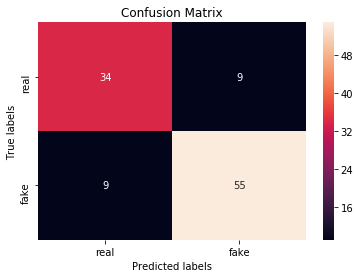

In [66]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

#### Exp3- Tf-Idf+ Preprocessed text 


In [194]:

x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', SVC(kernel='linear'))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C':[0.01,0.1,1,10]
}
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [69]:

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degre

In [70]:
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[34  9]
 [ 9 55]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.79      0.79      0.79        43
           1       0.86      0.86      0.86        64

    accuracy                           0.83       107
   macro avg       0.83      0.83      0.83       107
weighted avg       0.83      0.83      0.83       107
 

Train Accuracy 1.0
Test Accuracy: 0.8317757009345794
roc_auc_score 0.8250363372093023


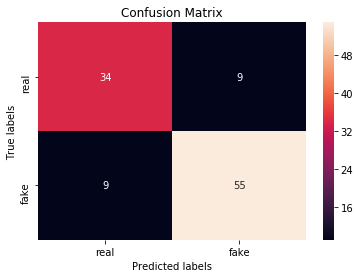

In [71]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

#### Exp4- Tf-Idf + Preprocessed text + Stemming

In [195]:

x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', SVC(kernel='linear'))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C':[0.01,0.1,1,10]
}
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [75]:
print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degre

In [76]:

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[36  7]
 [10 54]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.78      0.84      0.81        43
           1       0.89      0.84      0.86        64

    accuracy                           0.84       107
   macro avg       0.83      0.84      0.84       107
weighted avg       0.84      0.84      0.84       107
 

Train Accuracy 1.0
Test Accuracy: 0.8411214953271028
roc_auc_score 0.8404796511627907


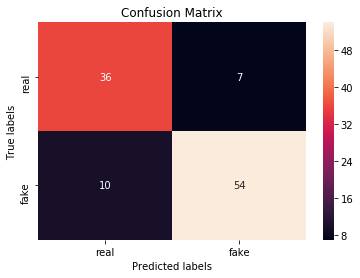

In [77]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

# Decision Tree Classifier


#### Exp1: Bow + Preprocessed text

In [78]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

BoW=CountVectorizer(stop_words='english')
X_train=BoW.fit_transform(X_train)
X_test= BoW.transform(X_test)

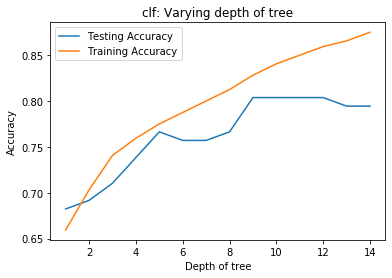

In [79]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 15)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a Decision Tree Classifier
    clf = sk.tree.DecisionTreeClassifier(random_state=42,max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, Y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, Y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, Y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

In [80]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', DecisionTreeClassifier(random_state=42,max_depth=9))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}


grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [81]:
print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=9, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                

In [82]:

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
# check the performance of model on both, train and validation. If training accuracy 
#is extremely high and testing is not the same, then the model is overfitting.
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[24 19]
 [ 2 62]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.92      0.56      0.70        43
           1       0.77      0.97      0.86        64

    accuracy                           0.80       107
   macro avg       0.84      0.76      0.78       107
weighted avg       0.83      0.80      0.79       107
 

Train Accuracy 0.828125
Test Accuracy: 0.8037383177570093
roc_auc_score 0.7634447674418604


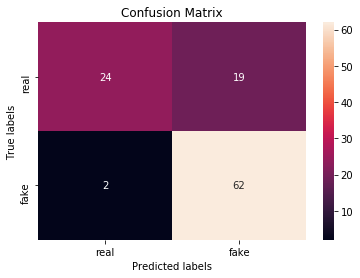

In [83]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

#### Exp2: Bow + Preprocessed text +Stemming


In [84]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

BoW=CountVectorizer(stop_words='english')
X_train=BoW.fit_transform(X_train)
X_test= BoW.transform(X_test)

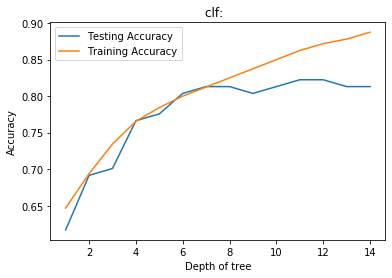

In [85]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 15)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a Decision Tree Classifier
    clf = sk.tree.DecisionTreeClassifier(random_state=42,max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, Y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, Y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, Y_test)

# Generate plot
plt.title('clf:  ')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

In [86]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', DecisionTreeClassifier(random_state=42,max_depth=6))])



In [87]:
grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [88]:
print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=6, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                

In [89]:
best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[24 19]
 [ 1 63]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.96      0.56      0.71        43
           1       0.77      0.98      0.86        64

    accuracy                           0.81       107
   macro avg       0.86      0.77      0.78       107
weighted avg       0.85      0.81      0.80       107
 

Train Accuracy 0.8
Test Accuracy: 0.8130841121495327
roc_auc_score 0.7712572674418605


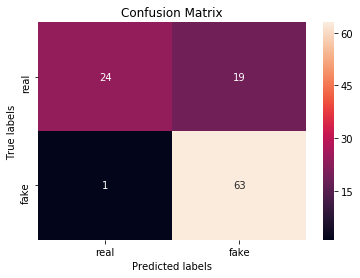

In [90]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

#### Exp3- Tf-Idf+ Preprocessed text 


In [91]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

BoW=TfidfVectorizer(stop_words='english')
X_train=BoW.fit_transform(X_train)
X_test= BoW.transform(X_test)



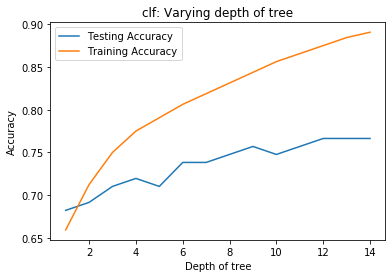

In [92]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 15)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a Decision Tree Classifier
    clf = sk.tree.DecisionTreeClassifier(random_state=42,max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, Y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, Y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, Y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

In [93]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', DecisionTreeClassifier(random_state=42,max_depth=9))])


In [94]:
grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}

In [95]:

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [96]:
print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token...,
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=9, max_features=None,
      

In [97]:
best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[21 22]
 [ 4 60]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.84      0.49      0.62        43
           1       0.73      0.94      0.82        64

    accuracy                           0.76       107
   macro avg       0.79      0.71      0.72       107
weighted avg       0.78      0.76      0.74       107
 

Train Accuracy 0.84375
Test Accuracy: 0.7570093457943925
roc_auc_score 0.7129360465116279


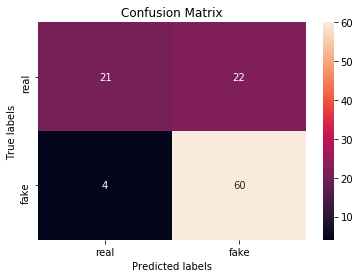

In [98]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);

#### Exp4- Tf-Idf + Preprocessed text + Stemming 

In [99]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

BoW=TfidfVectorizer(stop_words='english')
X_train=BoW.fit_transform(X_train)
X_test= BoW.transform(X_test)

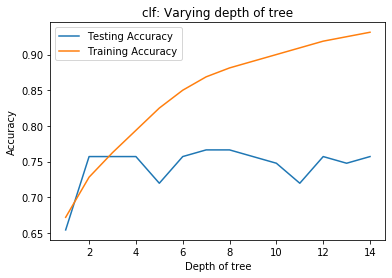

In [100]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 15)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a Decision Tree Classifier
    clf = sk.tree.DecisionTreeClassifier(random_state=42,max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, Y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, Y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, Y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

In [101]:


x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', DecisionTreeClassifier(random_state=42,max_depth= 5))])


In [102]:
grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}

In [103]:

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [104]:
print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))



Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token...,
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=5, max_features=None,
      

In [105]:
best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

Confusion matrix 
 [[23 20]
 [ 1 63]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.96      0.53      0.69        43
           1       0.76      0.98      0.86        64

    accuracy                           0.80       107
   macro avg       0.86      0.76      0.77       107
weighted avg       0.84      0.80      0.79       107
 

Train Accuracy 0.784375
Test Accuracy: 0.8037383177570093
roc_auc_score 0.7596293604651163


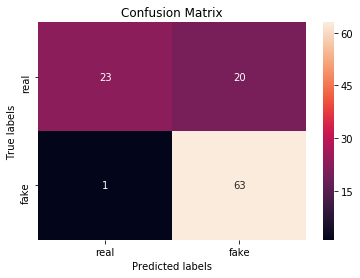

In [106]:
#confusion matrix plot

ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real', 'fake']);